## Import Modules

In [1]:
import os
import rasterio
import rasterio.mask
import numpy as np
import fiona
import shapely
import matplotlib.pyplot as plt
%matplotlib inline
from rasterio.plot import reshape_as_raster, reshape_as_image

## Load Sentinel Data

In [2]:
data_path = r"C:\SKOLA\MACHINE_LEARNING\projekt\data"

band_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and 'T30UXU_20230615T110629' in f]
band_files

['C:\\SKOLA\\MACHINE_LEARNING\\projekt\\data\\T30UXU_20230615T110629_B02_10m.jp2',
 'C:\\SKOLA\\MACHINE_LEARNING\\projekt\\data\\T30UXU_20230615T110629_B03_10m.jp2',
 'C:\\SKOLA\\MACHINE_LEARNING\\projekt\\data\\T30UXU_20230615T110629_B04_10m.jp2',
 'C:\\SKOLA\\MACHINE_LEARNING\\projekt\\data\\T30UXU_20230615T110629_B08_10m.jp2']

## Define Projection

In [3]:
# Define projection for each Sentinel band
for id, band_file in enumerate(band_files, start=1):
    with rasterio.open(band_file, 'r+') as src:
        src.crs = rasterio.crs.CRS.from_epsg(32630)
        meta = src.meta
    print(band_file + " " + str(src.crs))

C:\SKOLA\MACHINE_LEARNING\projekt\data\T30UXU_20230615T110629_B02_10m.jp2 EPSG:32630
C:\SKOLA\MACHINE_LEARNING\projekt\data\T30UXU_20230615T110629_B03_10m.jp2 EPSG:32630
C:\SKOLA\MACHINE_LEARNING\projekt\data\T30UXU_20230615T110629_B04_10m.jp2 EPSG:32630
C:\SKOLA\MACHINE_LEARNING\projekt\data\T30UXU_20230615T110629_B08_10m.jp2 EPSG:32630


## Composite Bands

In [4]:
# Create stack (composite all bands)
img_fp = data_path + "\\" + "sentinel_image.tif"

# update band count in metadata
meta.update(count = len(band_files))

with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(band_files, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

print(f"Composite saved to: {img_fp}")

Composite saved to: C:\SKOLA\MACHINE_LEARNING\projekt\data\sentinel_image.tif


## Image Attributes

In [5]:
# Image statistics and bands statistics
with rasterio.open(img_fp) as img:

    # Read all bands as array
    array = img.read()

print(f"Format: {img.driver}")
print(f"Rows: {img.shape[0]}, Columns: {img.shape[1]}")
print(f"{img.count} bands")
print(f"BBox: {img.bounds}")
print(f"EPSG: {rasterio.crs.CRS.to_epsg(img.crs)}")
print(f"Band Indexes: {img.indexes}")
print(f"NoData: {img.nodata}")

Format: JP2OpenJPEG
Rows: 10980, Columns: 10980
4 bands
BBox: BoundingBox(left=600000.0, bottom=5290200.0, right=709800.0, top=5400000.0)
EPSG: 32630
Band Indexes: (1, 2, 3, 4)
NoData: None


## Image Statistics

In [6]:
# Calculate statistics for each band
stats = []
for id, band in enumerate(array, start=1):
    stats.append({
        'band': id,
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

stats

[{'band': 1,
  'min': 0,
  'mean': 1513.6414118815132,
  'median': 1482.0,
  'max': 24467},
 {'band': 2,
  'min': 0,
  'mean': 1791.7789500698404,
  'median': 1776.0,
  'max': 22262},
 {'band': 3,
  'min': 0,
  'mean': 1766.476336865173,
  'median': 1680.0,
  'max': 20583},
 {'band': 4,
  'min': 0,
  'mean': 4260.297158221108,
  'median': 4429.0,
  'max': 18504}]

## Clip Image

In [7]:
# Load AOI shapefile
shp_fp = r"C:\SKOLA\MACHINE_LEARNING\projekt\data\aoi.shp"

with fiona.open(shp_fp, "r") as shapefile:
    driver = shapefile.driver
    feature_count = len(shapefile)
    crs = shapefile.crs

    print(f"Format: {driver}, Number of Features: {feature_count}, CRS: {crs}")
    
    # if shapefile CRS matches Sentinel Image CRS
    if fiona.crs.CRS.to_epsg(shapefile.crs) == rasterio.crs.CRS.to_epsg(img.crs):

        # read the geometry of AOI shapefile
        #feature = shapefile[0]
        shapes = [feature["geometry"] for feature in shapefile]

        print(f"Fiona Geometry object: {shapes}")
        for s in shapes:
            print(f"Fiona Geometry object as dictionary: {fiona.model.to_dict(s)}")

Format: ESRI Shapefile, Number of Features: 1, CRS: EPSG:32630
Fiona Geometry object: [<fiona.model.Geometry object at 0x000002940001E430>]
Fiona Geometry object as dictionary: {'coordinates': [[(604389.455336051, 5399874.512970487), (630352.8655218876, 5399796.231331736), (630483.3349198063, 5377772.996963046), (604128.5165402134, 5377981.747999716), (604389.455336051, 5399874.512970487)]], 'type': 'Polygon'}


In [8]:
# Clipping Sentinel image using AOI shapefile
clipped_img_fp = data_path + "\\" + "sentinel_image_clipped.tif"

with rasterio.open(img_fp) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

# update metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(clipped_img_fp, "w", **out_meta) as dest:
    dest.write(out_image)


print(f"Size of original image: {img.shape}")
print(f"Size of clipped image: {dest.shape}")

if (dest.shape[0] < img.shape[0]) and (dest.shape[1] < img.shape[1]):
    print("Clip succesful.")
else:
    print("Clip not succesful.")

Size of original image: (10980, 10980)
Size of clipped image: (2211, 2637)
Clip succesful.


## Image Visualization

#### Single Band Visualization

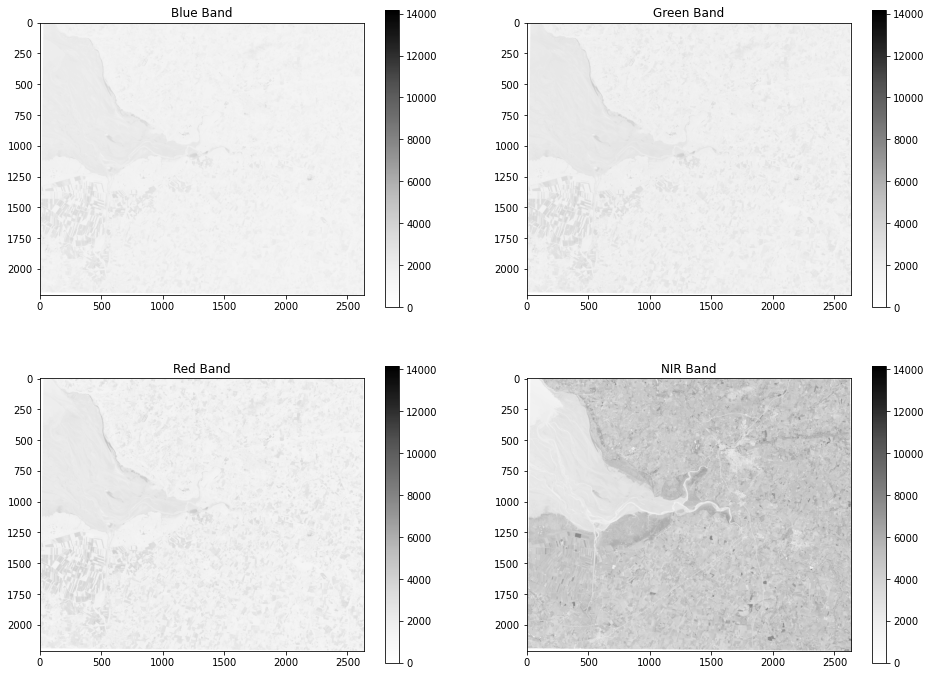

In [9]:
# open clipped image
with rasterio.open(clipped_img_fp) as img:
    image = img.read()
    image_meta = img.meta

# find max reflectance to put them on the same colorbar scale
# get max_ref of NIR and max_ref on BLUE, and get the max value of these two values
max_ref = np.max([np.max(image[3]), np.max(image[0])])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

blue = ax1.imshow(image[0], cmap=plt.cm.Greys)
ax1.set_title("Blue Band")
fig.colorbar(blue, ax=ax1)
blue.set_clim(vmin=0, vmax=max_ref)

green = ax2.imshow(image[1], cmap=plt.cm.Greys)
ax2.set_title("Green Band")
fig.colorbar(green, ax=ax2)
green.set_clim(vmin=0, vmax=max_ref)

red = ax3.imshow(image[2], cmap=plt.cm.Greys)
ax3.set_title("Red Band")
fig.colorbar(red, ax=ax3)
red.set_clim(vmin=0, vmax=max_ref)

nir = ax4.imshow(image[3], cmap=plt.cm.Greys)
ax4.set_title("NIR Band")
fig.colorbar(nir, ax=ax4)
nir.set_clim(vmin=0, vmax=max_ref)

#### RGB visualization

##### Using rasterio.plot.show

RGB max DN: 13692
RGB max DN after normalization: 1.0
(3, 2211, 2637)


<AxesSubplot:>

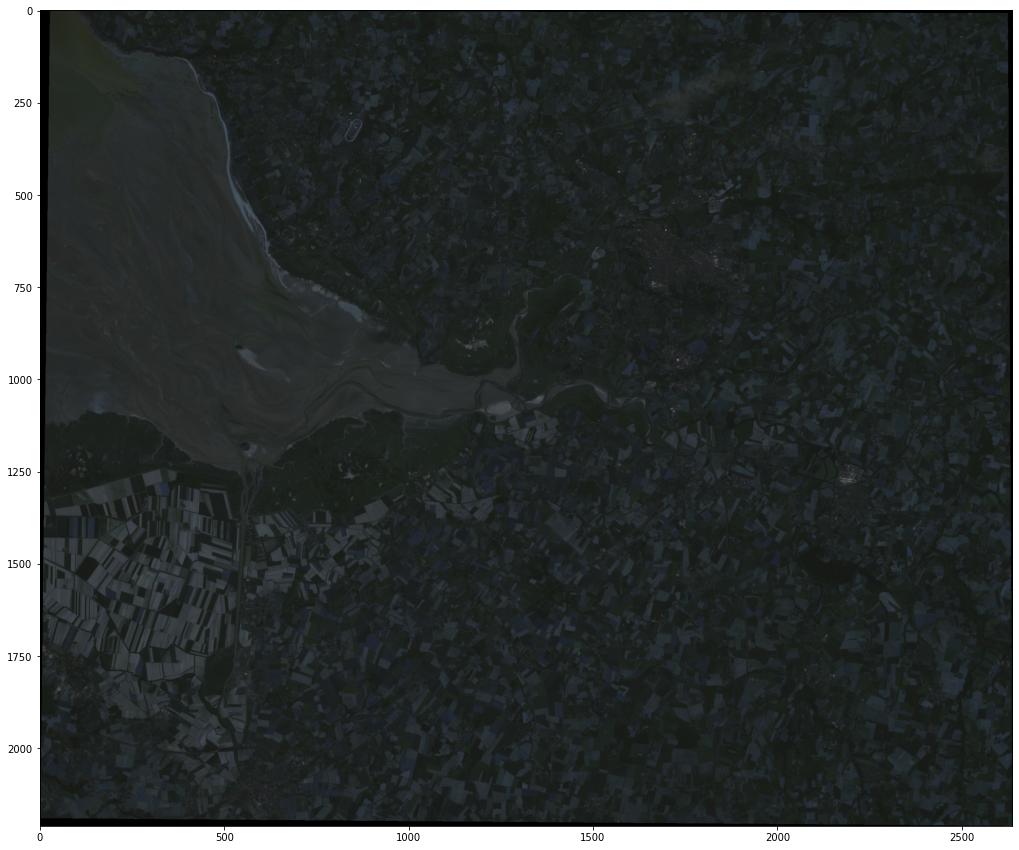

In [10]:
# RGB band extraction
rgb_image = image[0:3]

# required normalized DN values to 0-1 scale
rgb_image_norm = rasterio.plot.adjust_band(rgb_image)

print(f"RGB max DN: {np.amax(rgb_image)}")
print(f"RGB max DN after normalization: {np.amax(rgb_image_norm)}")

# rasterio.plot.show requires shape  (bands, rows, cols)
print(rgb_image_norm.shape)

fig, ax = plt.subplots(figsize=(20, 15))
rasterio.plot.show(rgb_image_norm, ax=ax)

##### Using matplotlib imshow

Reshaped from (3, 2211, 2637) to (2211, 2637, 3)


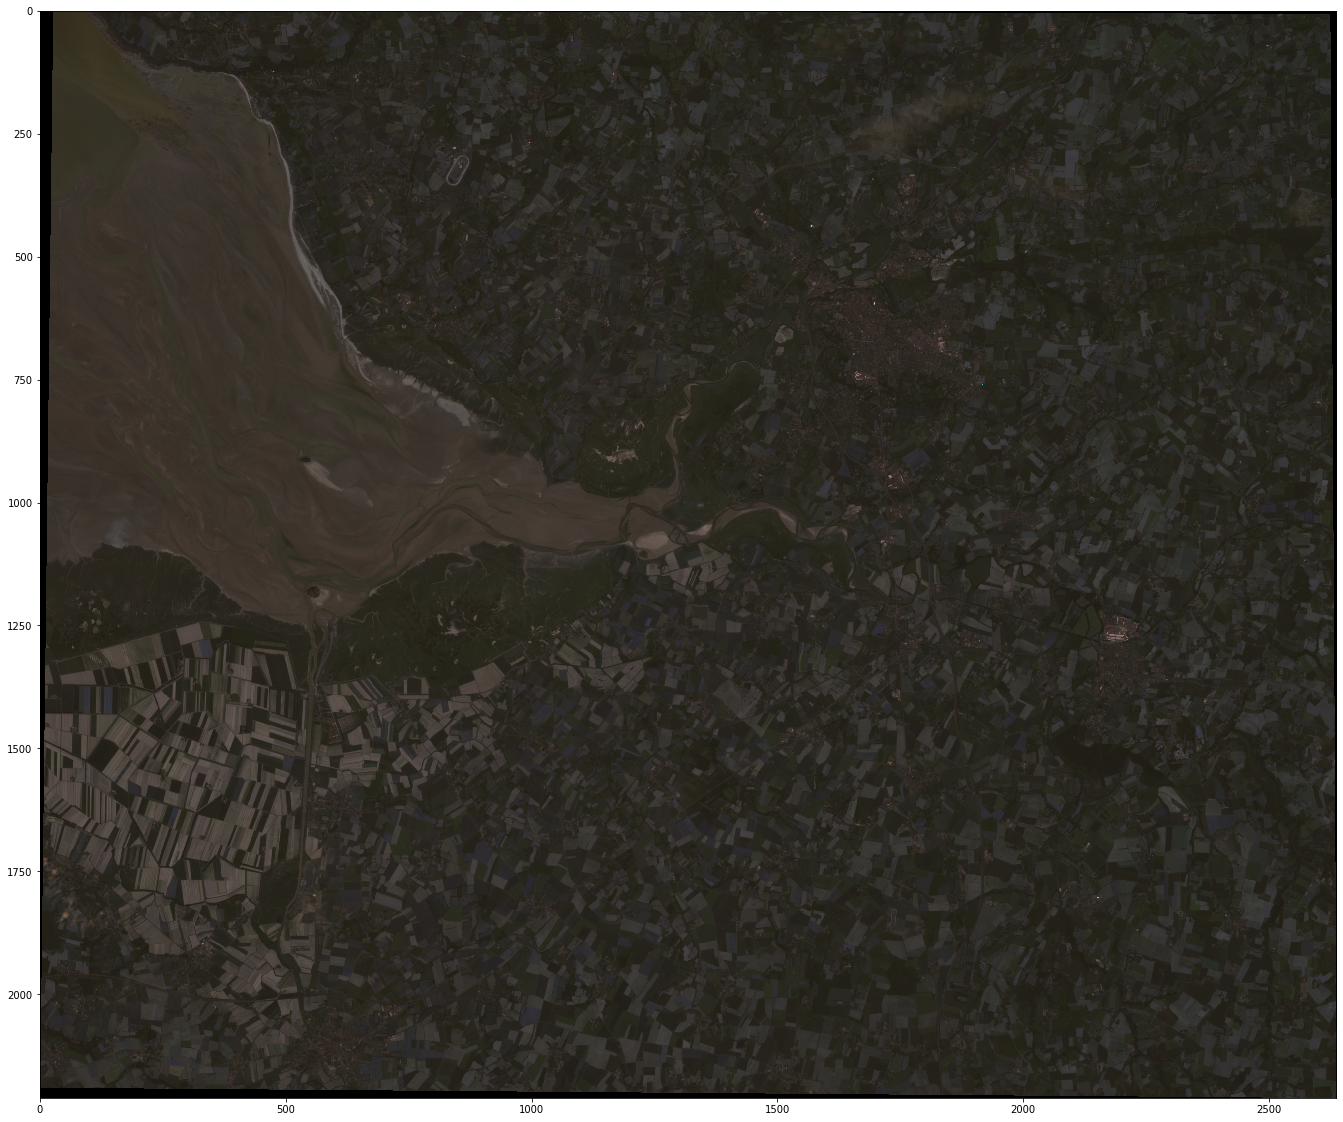

In [11]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

blue_norm = normalize(image[0])
green_norm = normalize(image[1])
red_norm = normalize(image[2])

# Stack bands
rgb_image_norm = np.array([blue_norm, green_norm, red_norm])

# imshow requires shape (M, N), or (M, N, 3), or (M, N, 4)... [rows, cols, bands]
rgb_image_norm_reshaped = rasterio.plot.reshape_as_image(rgb_image_norm)

print(f"Reshaped from {rgb_image_norm.shape} to {rgb_image_norm_reshaped.shape}")

# Using imshow
plt.figure(figsize = (50,20))
plt.imshow(rgb_image_norm_reshaped, interpolation='nearest')

##### Percent Clip normalization

B 0.0 - 1.0 mean: 0.3165159509263345
G 0.0 - 1.0 mean: 0.36100276680305154
R 0.0 - 1.0 mean: 0.34638556547589583
(3, 2211, 2637)


<AxesSubplot:>

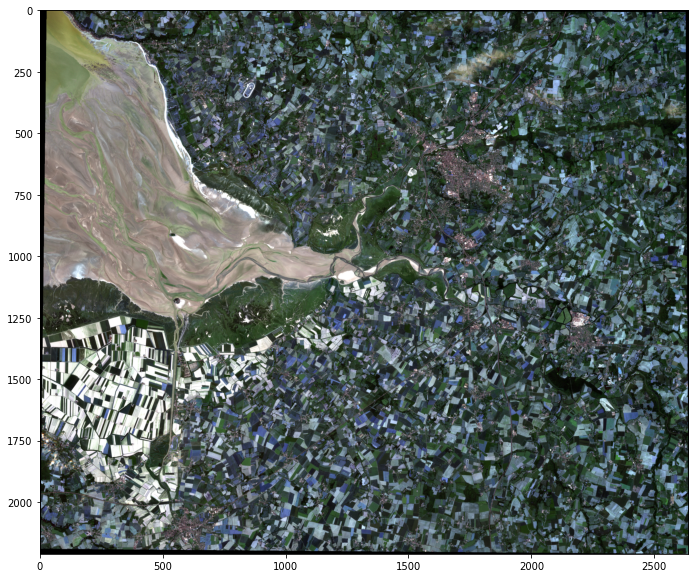

In [12]:
# Percent Clip
def pct_clip(array, pct=[1.5,98.5]):
    
    # Get min, max DN value for provided percentiles
    array_min_DN, array_max_DN = np.nanpercentile(array, pct[0]), np.nanpercentile(array, pct[1])

    # Normalize
    clip = (array - array_min_DN) / (array_max_DN - array_min_DN)

    # Normalized values above 1 are not in the provided percentile (too bright pixels), assing them the max value of 1
    clip[clip>1]=1

    # Normalized values under 0 are not in the provided percentile (too dark pixels), assing them the min value of 0
    clip[clip<0]=0
    
    return clip

blue_pct_clip = pct_clip(image[0])
green_pct_clip = pct_clip(image[1])
red_pct_clip = pct_clip(image[2])
nir_pct_clip = pct_clip(image[3])

print("B", blue_pct_clip.min(), '-', blue_pct_clip.max(), 'mean:', blue_pct_clip.mean())
print("G", green_pct_clip.min(), '-', green_pct_clip.max(), 'mean:', green_pct_clip.mean())
print("R", red_pct_clip.min(), '-', red_pct_clip.max(), 'mean:', red_pct_clip.mean())

rgb_pct_clip = np.array([blue_pct_clip, green_pct_clip, red_pct_clip])

# rasterio.plot.show requires shape  (bands, rows, cols)
print(rgb_pct_clip.shape)

fig,ax=plt.subplots(figsize=(20, 10))
rasterio.plot.show(rgb_pct_clip, ax=ax)

## False Color Composite

(2211, 2637, 3)


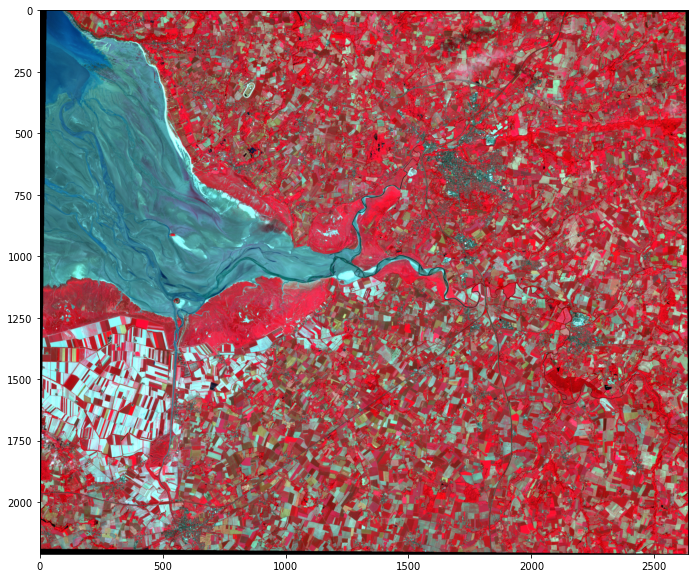

In [13]:
# (NIR, RED, GREEN) composite (4, 3, 2)
composite_pct_clip = np.dstack((nir_pct_clip, red_pct_clip, green_pct_clip))

print(composite_pct_clip.shape)

fig,ax=plt.subplots(figsize=(20, 10))
ax.imshow(composite_pct_clip)

In [14]:
# Saving composite
composite_fp = data_path + "\\" + "composite.tif"

# Update metadata of the composite image
composite_meta = image_meta
composite_meta.update(count=3)

# create composite
composite = np.dstack((image[3],  image[2], image[1]))
print(composite.shape)

# exporting raster requires shape (bands, rows, columns)
composite = reshape_as_raster(composite)
print(composite.shape)

with rasterio.open(composite_fp, 'w', **composite_meta) as dst:
    dst.write(composite)
    print(f"Export successful: {composite_fp}")

(2211, 2637, 3)
(3, 2211, 2637)
Export successful: C:\SKOLA\MACHINE_LEARNING\projekt\data\composite.tif


## NDWI and NDVI

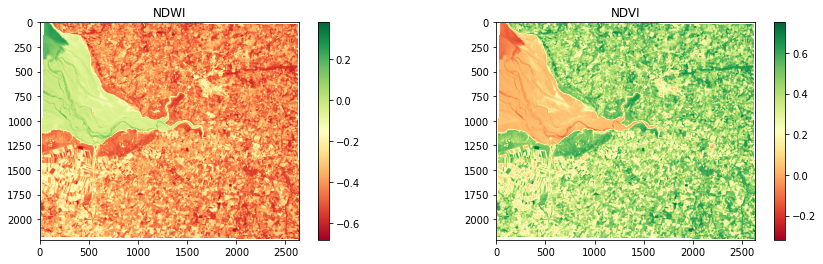

In [15]:
# Suppress/hide the warning when dividing by zero
np.seterr(invalid='ignore')

green = image[1]
red = image[2]
nir = image [3]

# NDWI a NDVI
ndwi = (green.astype(float) - nir.astype(float)) / (green.astype(float) + nir.astype(float))
ndvi = (nir.astype(float) - red.astype(float)) / (red.astype(float) + nir.astype(float))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ndwi_plot = ax1.imshow(ndwi, cmap="RdYlGn")
ax1.set_title("NDWI")
fig.colorbar(ndwi_plot, ax=ax1)

ndvi_plot = ax2.imshow(ndvi, cmap="RdYlGn")
ax2.set_title("NDVI")
fig.colorbar(ndvi_plot, ax=ax2)

## Image Classification

##### Load Training Data

In [16]:
# Load training data SHP
shp_path = r"C:\SKOLA\MACHINE_LEARNING\projekt\data\ground_truth.shp"

# Open training data and print properties
with fiona.open(shp_path, "r") as shapefile:
    driver = shapefile.driver
    feature_count = len(shapefile)
    spatial_ref = shapefile.crs
    schema = shapefile.schema
    geometry_type = schema['geometry']
    attributes = schema['properties']
    profile = shapefile.profile

    print(f"Format: {driver}")
    print(f"Geometry Type: {geometry_type}")
    print(f"Feature Count: {feature_count}")
    print(f"EPSG: {fiona.crs.CRS.to_epsg(spatial_ref)}")
    print(f"Attributes and Data Types: {attributes}")
    print(f"Attribute Names: {list(attributes.keys())}")  

Format: ESRI Shapefile
Geometry Type: Polygon
Feature Count: 364
EPSG: 32630
Attributes and Data Types: {'id': 'int:10', 'classname': 'str:80', 'class': 'int:10'}
Attribute Names: ['id', 'classname', 'class']


##### Get training pixels and it's features and pair them with corresponding class label
<img src="C:\SKOLA\MACHINE_LEARNING\projekt\obr_maska_prveho_polygonu.png" width="100" height="100"/>

In [17]:
with fiona.open(shp_path, "r") as shapefile:
    
    with rasterio.open(clipped_img_fp) as img:

        # array for pixel DN values (features)
        X = np.array([], dtype=np.int8).reshape(0, img.count)
    
        # array of corresponing label of a pixel, class stored as integer
        # one long array, where each element will correspond to one pixel in X array (positionally)
        y = np.array([], dtype=np.int8)
    
        # For each training polygon
        for feature in shapefile:
                
            # Create/Load Fiona Geometry Object
            shape = [feature["geometry"]]
    
            # Mask out sentinel pixels within polygon
            out_image, out_transform = rasterio.mask.mask(img, shape, crop=True)
    
            # Remove masked-out pixels with value 0 (they are not part of the polygon), see image above
            out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
                
            # Creates 2D long array long (bands, n) (bands - number of bands (4), n -length, pixel count in the polygon (first polygon 165 px))
            # Need shape (n, bands) where rows will be unique pixels (n pixels), columns DN value of each band (4 bands)
            # Transpose
            out_image_reshaped = out_image_trimmed.T
    
            # vertically stacking the pixels in the pixel array
            X = np.vstack((X, out_image_reshaped))
    
            # append the labels to the y array, ... * append number of times = number of pixels in particular polygon
            y = np.append(y, [feature['properties']['class']] * out_image_reshaped.shape[0])

print(f"Array of DN values (features) of training pixels:\n{X}\n")
print(f"Array of labels (classes) of training pixels:\n{y}\n")

print(f"Size of array of DN values (features) of training pixels: {X.shape}")
print(f"Size of array of labels (classes) of training pixels: {y.shape}")

Array of DN values (features) of training pixels:
[[2226 2322 2432 2677]
 [2226 2277 2347 2732]
 [2090 1967 1949 2447]
 ...
 [1376 1636 1490 5112]
 [1313 1568 1370 5382]
 [1336 1553 1384 5413]]

Array of labels (classes) of training pixels:
[1 1 1 ... 4 4 4]

Size of array of DN values (features) of training pixels: (96086, 4)
Size of array of labels (classes) of training pixels: (96086,)


##### Connecting class numbers with class names

In [18]:
# Shapefile with training polygons has 2 attributes: classname (string); class (integer)
with fiona.open(shp_path, "r") as shapefile:

    # classnames (strings)
    class_names = np.unique([feature['properties']['classname'] for feature in shapefile])
    print(f"{class_names.size} class names found: {class_names}")

    # classes (integers)
    classes = np.unique(y)
    print(f"{classes.size} class numbers found: {classes}")

    class_names = []
    for class_number in classes:
        # find polygon with the correct class number
        for feature in shapefile:
            if feature['properties']['class'] == class_number:
                
                # create a list, where the position of a classname will correspond with the class number (integer) 
                class_names.insert(int(class_number)-1, feature['properties']['classname'])
                
                break
        continue

# dictionary of a classification legend - class number corresponds with class name
legend = dict(zip(classes, class_names))
print(f"\nThe classification legend is:\n{legend}")

6 class names found: ['bazina' 'les' 'orna poda' 'voda' 'zastavba' 'zatravnena plocha']
6 class numbers found: [1 2 3 4 5 6]

The classification legend is:
{1: 'zastavba', 2: 'voda', 3: 'bazina', 4: 'zatravnena plocha', 5: 'les', 6: 'orna poda'}


##### Class Separability Visual Analysis

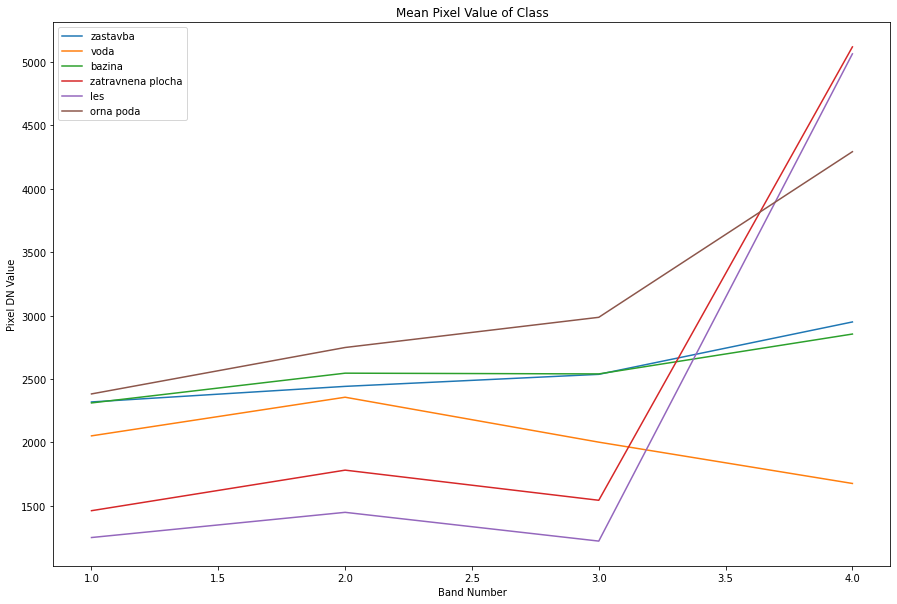

In [19]:
fig, ax = plt.subplots(figsize=(15,10))

# band numbers, arange stop is exclusive so +1 needed 
band_numbers = np.arange(1, image.shape[0] + 1)

# from X array, where the DN values of training pixels are stored, pick just pixels of one class
for class_num in classes:
    
    # just rows (pixels) of particular class, all column (bands, DN values)
    class_pixels = X[y==class_num, :]
    
    # compute mean of DN values of each band, axis = 0 means computing in columns (bands)
    mean_value = np.mean(class_pixels, axis=0)

    # in legend get the class name from classification legend dictionary
    ax.plot(band_numbers, mean_value, label=legend.get(class_num))
    
    ax.set_title("Mean Pixel Value of Class")
    ax.set_xlabel('Band Number')
    ax.set_ylabel('Pixel DN Value')
    ax.legend(loc="upper left")

##### Random Forest using sci-kit

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest with default parameters
rf = RandomForestClassifier()

# Train RF
rf.fit(X, y)

RandomForestClassifier()

In [21]:
print(image.shape)

# for classification required shape is (rows = pixels, columns = bands/features)
# first reshape image array (raster shape) to image shape (bands, rows, columns) to (rows, columns, bands)
image_reshaped = reshape_as_image(image)
print(image_reshaped.shape)

# then reshape again: -1 is now unknown size (will be determined during the reshaping), in this case it is the number of pixels being classified (rows)
# image.shape[-1] is the number of bands/features (4) (columns)
image_for_classification = image_reshaped.reshape(-1, image_reshaped.shape[-1])

print(f"Reshaped for classification to: {image_for_classification.shape}")

# apply RF model
class_prediction = rf.predict(image_for_classification)

# the result of classification is one long array (n) of class numbers, n - number of classified pixels
print("Classification result:")
print(class_prediction.shape)
print(class_prediction)

# convert the classification result to the original image shape (rows, columns) bands = 0 (no bands, classified image consists just of class numbers)
classified_image = class_prediction.reshape(image_reshaped.shape[0], image_reshaped.shape[1])
print(classified_image.shape)
print(classified_image)

(4, 2211, 2637)
(2211, 2637, 4)
Reshaped for classification to: (5830407, 4)
Classification result:
(5830407,)
[2 2 2 ... 4 4 2]
(2211, 2637)
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 4 4 2]
 [2 2 2 ... 4 4 2]
 [2 2 2 ... 4 4 2]]


## Classification Visualization

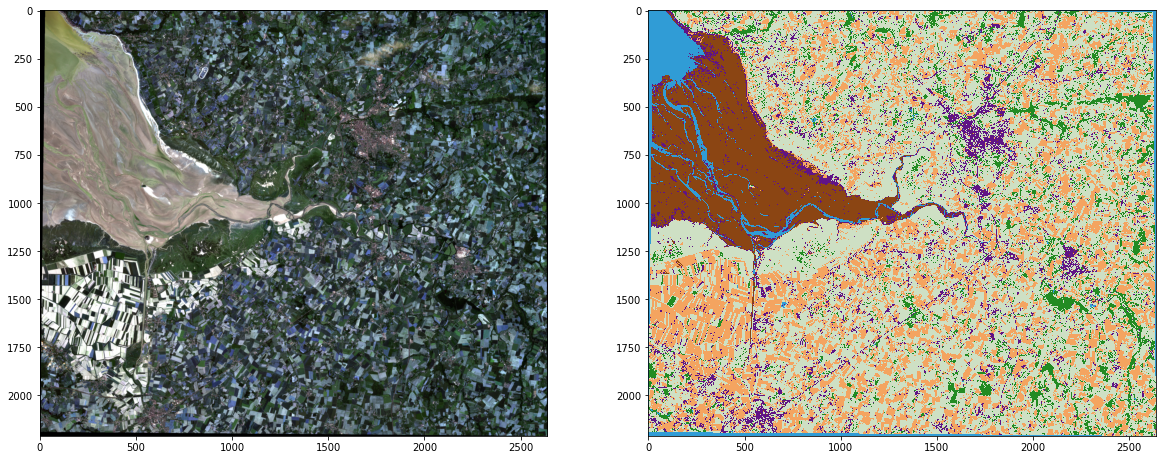

In [22]:
# find the highest pixel value in the classified image
n = int(np.max(classified_image))

# colormap
colors = dict((
    (0, (96, 19, 134, 255)),   # Purple - Zastavba 
    (1, (48, 156, 214, 255)),      # Blue - Voda
    (2, (139,69,19, 255)),    # Brown - Bazina
    (3, (206, 224, 196, 255)),   # Lime - Zatravnena plocha 
    (4, (34, 139, 34, 255)),  # Forest Green - Les 
    (5, (244, 164, 96, 255)),    # Tan - Orna poda 
))

# normalize RGB values of colors
for k in colors:
    v = colors[k]
    values = []
    for c in v: 
        normalized_value = c/255.0
        values.append(normalized_value)
    colors[k] = values

# creation of matplotlib colormap requires colors in a list: [[R, G, B, A], [R, G, B, A], ...]]
norm_colors_list = list(colors.values())
cmap = plt.matplotlib.colors.ListedColormap(norm_colors_list)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))

ax1.imshow(reshape_as_image(rgb_pct_clip))
ax2.imshow(classified_image, cmap=cmap, interpolation='none')

## Classification Export

In [23]:
classified_image_fp = data_path + "\\" + "rf_classification_new.tif"

with rasterio.open(clipped_img_fp) as src:
    classification_meta = src.meta

classification_meta.update({"driver": "GTiff",
                 "height": classified_image.shape[0],
                 "width": classified_image.shape[1],
                 "count": 1})

with rasterio.open(classified_image_fp, "w", **classification_meta) as dest:
    dest.write(classified_image, indexes=1)